# Finding Similar Items: Textually Similar Documents 

We will implement the minhashing algorithm for finding similar items or documents of textual character.  

## Python implementation :

First import all the necessary packages

In [2]:
import sympy
import random
import numpy as np
import binascii
import json
from ordered_set import OrderedSet
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score

#### K-shingles implementation

We need to implement k-shingles for finding different shingles of size k for a given text document on the character level. **Example:** Suppose our document D is the string abcdabd, and we pick k = 2. Then the set of 2-shingles for D is {ab, bc, cd, da, bd}

In [10]:
def k_shingles(document, k):
    
    shingles = OrderedSet()
    shings = OrderedSet()
    
    for i in range(len(document) - k + 1 ):
        temp_shingle = document[ i:(i + k ) ]
        shingles.add(hash(temp_shingle))
        shings.add(temp_shingle)
        
    return shingles, shings

We will redo the example in python in order to verify the validaity of the implementation and test the function in general 

In [11]:
document = "abcdabd"
k = 2
_, shingles = k_shingles(document, k)
print(shingles)

OrderedSet(['ab', 'bc', 'cd', 'da', 'bd'])


The result obtained seems correct. Next we need to hash this shingles to a bucket in the range $[0, 2^{32} - 1 ]$. This can be obtained in different ways. We can create a simple hash function that doing the following operation $shingles \rightarrow [0, 2^{32} - 1 ]$ or we can use a library function. Here we have implemented the two methods for comparison purposes.

In [12]:
def hash(text, M = 2**32 - 1) :
    # Simple hash function
    xlength = len(text)
    sum = 0
    
    for i in range(xlength) :
        sum += ord(text[i])
        
    return ( sum % M)
    
def hash_with_binascii(text) :
    # Encode eaxh text to [0, 2^{32} - 1 ] with binascii library
    hash = binascii.crc32(text.encode())
    return hash 

Continuing with our example document, we can now hash its shingles :

In [13]:
document = "abcdabd"
k = 2
shingles_encode, shingles = k_shingles(document, k)
print(list(shingles))
print(list(shingles_encode))


['ab', 'bc', 'cd', 'da', 'bd']
[195, 197, 199, 198]


##### Universal set

The universal set can be defined as the union of all the documents. Given that each document can have a different number of shingles in their set, the comparison is impossible. We need to create a universal set U, in order to normalise each set to have the same length. 

In [14]:
def universal_set(documents, k) :
    
    universal = OrderedSet()
    universal1 = OrderedSet()
    for doc in documents :
        #print("doc = ", doc)
        shingles, shings = k_shingles(doc, k)
        universal = universal.union(shingles)
        universal1 = universal1.union(shings)
    
    universal = list(universal)
    universal1 = list(universal1)
    universal.sort()
    universal1.sort()
    universal = OrderedSet(universal)
    universal1 = OrderedSet(universal1)
    
    return universal, universal1

**Example:** let's have four documents : 
    1. s1 = 'ad'
    2. s2 = 'c'
    3. s3 = 'bde'
    4. s4 = 'acd'
The uniion of all the character for k = 1, is {a,b,c,d,e} (no duplicates). That is the universal set is {a,b,c,d,e}. We can now represent each document $s_1, s_2, s_3, s_4$ in term of the universal set. Let's take document s1 as an example, its representation is s1 = {1,0,0,1,0}. s1 has 1 in the first and fourth element because it shares shingle "a" and "d" with the universal set. We can do the same with other documents. 

In [68]:
s1 = 'ad'
s2 = 'c'
s3 = 'bde'
s4 = 'acd'
k = 1
documents = [s1,s2,s3,s4]
_, universalSet = universal_set(documents, k)
print(list(universalSet))

['a', 'b', 'c', 'd', 'e']


The result is correct. 


###### Characteristic matrix

The characteristic matrix is the matrix representation of each documents in terms of the universal set. We have found that the universal set is {a,b,c,d,e}. s1 = {1,0,0,1,0} in term of the universal set and s2 = {0,0,1,0,0} etc. The characteristic matrix is [s1, s2, s3, s4], where each s is the transpose of the boolean vector representation of each document. 

In [17]:
def matrix_set(documents, k) :
    universal, universal1 = universal_set(documents, k)
    matrices = []
    
    for doc in documents :
        matrixSet = np.zeros(len(universal))
        shingles, shings = k_shingles(doc, k)
        for s in shingles :
            indx = universal.index(s)
            matrixSet[indx] = 1
            
        matrices.append(matrixSet.tolist())
    
    return np.array(np.transpose(matrices))


In [18]:
s1 = 'ad'
s2 = 'c'
s3 = 'bde'
s4 = 'acd'
k = 1
documents = [s1,s2,s3,s4]
characteristic_mat = matrix_set(documents, k)
print("The characteristic matrix : ")
print(characteristic_mat)

The characteristic matrix : 
[[1. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 1.]
 [0. 0. 1. 0.]]


The result seems correct !

###### Comparing sets

Now that we have the matrix representation of each documents, we can now compare two documents given their respective set vector representation. In order to do we will use the jaccard similarity : 
    $Jaccard(A,B) = \frac{A \cap B}{A \cup B} $

In [25]:
def CompareSets(setA, setB) :
    A = setA.intersection(setB)
    B = setA.union(setB)
    
    return (len(A)/len(B))

def compareByJaccard(documents,k,index1 = 10, index2 = 11 ) :
    
    allDocs = [] 
    for doc in documents :
        shingles, shings = k_shingles(doc, k)
        allDocs.append(shingles)

    
    return CompareSets(allDocs[index1] , allDocs[index2])

In [28]:
index1 = 0
index2 = 3
comparison = compareByJaccard(documents,k,index1, index2)
print("Comparison :")
print(documents[index1])
print(documents[index2])
print("Similarity : ", comparison)

Comparison :
ad
acd
Similarity :  0.6666666666666666


### MinHashing

Given that we have the characteristic matrix we need to find different permuations of the row elements of the matrix. 
it is computational expensive to ($N!$) for N rows. There we can generate instead N hash functions and use them to create an illusion of rows permutations. The N hash functions need to be of the forms :

$H(row_i) = ((a * row_i + b) \mod  c ) \mod  M $


Where a and b are two different no repeating integer in the range of $[0, 2^{32} - 1 ]$. M is the number of row in the characteristic matrix, c is a prime number such as c > M. 



#### Generate hash functions

Here we will use a slightly different implementation. 
1. First generate coefficients a and b :
    Given P the number of hash functions, we generate two list a and b of length P with the property described above
2. Next compute the row permutation as :
    for i in [1 ,..., NumberOfHashes ] :
        Hash_i = ((a * all_rows_as_list + b) mod  c ) mod  M  

In [30]:
def generate_coefficient_list(number_of_coefficients):
    max = 2**32 - 1
    next_prime = 4294967311
    coeffs = []
    
    def random_int():
        return random.randint(1, max)
    
    for _ in range(number_of_coefficients):
        temp = random_int()
        while temp in coeffs:
            temp = random_int()
        coeffs.append(temp)
    
    return coeffs
    

def generateMinHashFunctions(M, Snumb):
    """
    h(row_i)=(a*row_i + b) mod c
    """
    hashes = [] 
    k = np.arange(1,M)

    coeffs_a = generate_coefficient_list(Snumb)
    coeffs_b = generate_coefficient_list(Snumb)

    row = np.arange(M)
    c = sympy.nextprime(M+1)
    
    for i in range(Snumb):
        hash_i = ( (coeffs_a[i]*row + coeffs_b[i]) % c ) % M
        hashes.append(hash_i.tolist())
    
    return hashes

#### Compute minHash signatures 

The minHash signatures is the compressed version of the matrix set in order to speed up the time need to compare two documents. minHash signatures is a matrix of where the number of rows is equal to the number of hash functions and the number of colums is equal to the number of documents. The python implementation shows how it can be implemented. Look up at the book Mining of masssive datasets for further details

In [32]:
def MinHashing(documents,k,Snumb = 100):
    characteristic_mat = matrix_set(documents, k)
    M, nDocs = np.shape(characteristic_mat)
    hashes = generateMinHashFunctions(M, Snumb)
    signature = np.ones((Snumb, nDocs)) * np.inf
    
    for row_r in range(M) :
        for col_c in range(nDocs) :
            if characteristic_mat[row_r,col_c] == 1 :
                for i, h_i in enumerate(hashes) :
                     signature[i,col_c]  = min(h_i[row_r],  signature[i,col_c])

    
    return signature
    


In [33]:
def jaccard_sim_minhashing(signature, index1, index2) :
    signature = np.array(signature)
    A = signature[:,index1].tolist()
    B = signature[:,index2].tolist()
    
    total = len(A)
    commun = 0 
    for i in range(len(A)) :
        if A[i] == B[i] :
            commun += 1
    
    return (commun/total)

The jaccard similarity here is just the fraction between the number of times set A and B have the same element by the total number of element in set A or B (length(A) = length(B))

#### Finding similar documents 

In order to find similar document in a set of documents, we need to decide on a similarity thresold to be used say $s = 0.6$, then all the documents have similarity $ s \geq 0.6 $ are considered as similar. In python, we get  :

In [48]:
def similar_document(documents, k = 5, s = 0.6) :
    
    signature = MinHashing(documents, k)
    indices = []
    total = len(documents)
    for i in range(total) :
        for j in range(i, total) :
            sim = jaccard_sim_minhashing(signature, i,j)
            if sim > s and (i != j) :
                indices.append([i,j])

    print("similar docs : ",indices )

Going back to our examples, we have : 

In [50]:
s1 = 'ad'
s2 = 'c'
s3 = 'bde'
s4 = 'acd'
k = 1
s = 0.8
documents = [s1,s2,s3,s4]
similar_document(documents, k, s)

similar docs :  [[0, 3]]


The result seems correct, because "ad" and "acd" are quite similar. Although the result can be different for different s, k and the randomization of the system. Furtheremore there is risk for collisions. That is why we need a big amount of hash functions

### Tests functions and result plots 

In [51]:
def read_data():
    f = open('dataDuplicates.json')
    filen = json.load(f)
    dataset = filen['texts']
    return dataset
 
    
def similar_docs(k = 5, untilInd = 50) :
    
    data = read_data()
    documents = data[0:untilInd]
    s = 0.6
    signature = MinHashing(documents, k)
    indices = []
    total = len(documents)
    for i in range(total) :
        for j in range(i, total) :
            sim = jaccard_sim_minhashing(signature, i,j)
            if sim > s and (i != j) :
                indices.append([i,j])

    print("similar docs : ",indices )
    
def MinHashing_test(Snumb = 2):
    characteristic_mat = np.array([[1. ,0., 0., 1.],[0., 0., 1., 0.],[0., 1., 0., 1.],[1., 0., 1. ,1.],[0. ,0., 1., 0.]])
    M, nDocs = np.shape(characteristic_mat)
    hashes = [[1, 2, 3, 4, 0], [1, 4, 2, 0, 3]]
    signature = np.ones((Snumb, nDocs)) * np.inf
    
    for row_r in range(M) :
        for col_c in range(nDocs) :
            if characteristic_mat[row_r,col_c] == 1 :
                for i, h_i in enumerate(hashes) :
                     signature[i,col_c]  = min(h_i[row_r],  signature[i,col_c])

    return signature 
    
def test_time_hashing(k = 5, untilInd = 20) :
    data = read_data()
    documents = data[0:untilInd]
    s = 0.6
    signature = MinHashing(documents, k)
    
def similar_docs_accaracy(k = 5, untilInd = 50) :
    data = read_data()
    documents = data[0:untilInd]
    s = 0.8
    signature = MinHashing(documents,k, )
    indices = []
    indices_true = []
    total = len(documents)
    for i in range(total) :
        for j in range(i, total) :
            sim = jaccard_sim_minhashing(signature, i,j)
            if sim > s and (i != j) :
                indices.append([i,j])
            sim = compareByJaccard(documents,k,index1 = i, index2 = j )
            if sim > s and (i != j) :
                indices_true.append([i,j])
    print("indices : ",indices)
    print("indices_true : ",indices_true)   
    a = [sum(x) for x in indices ]   
    b = [sum(x) for x in indices_true ]   
    
    count = 0
    for element in b :
        if element in a :
            count += 1

    return (count / max(len(a),len(b) ) ) 
    
    
def similar_docs_accaracy_hashes(nHash = 20, k = 5, untilInd = 50) :
    data = read_data()
    documents = data[0:untilInd]
    s = 0.8
    signature = MinHashing(documents,k, nHash)
    indices = []
    indices_true = []
    total = len(documents)
    for i in range(total) :
        for j in range(i, total) :
            sim = jaccard_sim_minhashing(signature, i,j)
            if sim > s and (i != j) :
                indices.append([i,j])
            sim = compareByJaccard(documents,k,index1 = i, index2 = j )
            if sim > s and (i != j) :
                indices_true.append([i,j])
    print("indices : ",indices)
    print("indices_true : ",indices_true)   
    a = [sum(x) for x in indices ]   
    b = [sum(x) for x in indices_true ]   
    
    count = 0
    for element in b :
        if element in a :
            count += 1

    return (count / max(len(a),len(b) ) ) 
      
def tests() :
    
    s1 = 'ad'
    s2 = 'c'
    s3 = 'bde'
    s4 = 'acd'
    
    
        
    documents = [s1,s2,s3,s4]
    print(hash(s4))
    print()
    
    k = 1
    s1_shingles = k_shingles(s1, k)
    s2_shingles = k_shingles(s2, k)
    s3_shingles = k_shingles(s3, k)
    s4_shingles = k_shingles(s4, k)
    print()
    print("s1_shingles = ", s1_shingles)
    print("s2_shingles = ", s2_shingles)
    print("s3_shingles = ", s3_shingles)
    print("s4_shingles = ", s4_shingles)
    print()
    print(universal_set(documents,k))
    print()
    print(matrix_set(documents,k))
    print("Fictive permutation")
    print(generateMinHashFunctions(M=10, Snumb = 4))
    print()
    print("---------------------------------------")
    
    print(MinHashing_test())
    print("---------------------------------------")
    signature = MinHashing_test() 
    print("similarity : ", jaccard_sim_minhashing(signature, 0,3))
    print("*****************---------------******************")
    signature = MinHashing(documents,k)
    print("signature = ")
    print(signature)
    print("similarity Alldocs: ", jaccard_sim_minhashing(signature, 0,3))

def testsDocs() :
    data = read_data()
    documents = data[0:40]
    k = 5
    s = 0.6
    signature = MinHashing(documents,k)
    indices = []
    indices_true = []
    total = len(documents)
    for i in range(total) :
        for j in range(i, total) :
            sim = jaccard_sim_minhashing(signature, i,j)
            if sim > s and (i != j) :
                indices.append([i,j])
            sim = compareByJaccard(documents,k,index1 = i, index2 = j )
            if sim > 0.5 and (i != j) :
                indices_true.append([i,j])
    print("dataset")
    print(documents)
    print("signature = ")
    print(signature)
    docA = 16
    docB = 17
    print("docA : ", documents[docA])
    print("docB : ", documents[docB])
    print("similarity docA and docB : ", jaccard_sim_minhashing(signature, docA,docB))
    print()
    print(compareByJaccard(documents,k,index1 = docA, index2 = docB ) )
    print("similar docs : ",indices )
    print("similar docs true : ", indices_true )

def test1() :
    
    documents = ["la vie est belle mon amie", "la vida es muy bonita mi amiga", "la vie est bella mon amir",  "hfjfds fjjfds dkf", "vida vie amigo amiga to ", "why to do this hehe hehe", "vida es muy bonita min amigo"]
    k = 5
    s = 0.8
    signature = MinHashing(documents,k)
    indices = []
    indices_true = []
    total = len(documents)
    for i in range(total) :
        for j in range(i, total) :
            sim = jaccard_sim_minhashing(signature, i,j)
            if sim > s and (i != j) :
                indices.append([i,j])
            sim = compareByJaccard(documents,k,index1 = i, index2 = j )
            if sim > 0.5 and (i != j) :
                indices_true.append([i,j])
    print("dataset")
    print(documents)
    print("signature = ")
    print(signature)
    docA = 1
    docB = 6
    print("docA : ", documents[docA])
    print("docB : ", documents[docB])
    print("similarity docA and docB : ", jaccard_sim_minhashing(signature, docA,docB))
    print()
    print(compareByJaccard(documents,k,index1 = docA, index2 = docB ) )
    print("similar docs : ",indices )
    print("similar docs true : ", indices_true )
 
 
def plot_execution_time(temps = 10) :
    
    index = []
    s = 1
    timers = []
    for i in range(temps):
        start = time.time()
        test_time_hashing(k = 5, untilInd = s)
        elapsed =  time.time() - start
        s = 2*s
        timers.append(elapsed)
        index.append(s)
    
    plt.xlabel('Problem size')
    plt.ylabel('Execution time')
    plt.plot(index, timers, 'r-o')
    plt.show()
  
   


In [54]:
def test_shingle_size_accuracy() :
    
    size = np.arange(1,9)
    accuracies = []
    for k in size :
        acc = similar_docs_accaracy(k, untilInd = 50) * 100
        accuracies.append(acc)
    
    plt.xlabel('Shingle size')
    plt.ylabel('Accuracy')
    plt.plot(size, accuracies, 'r-o')
    plt.show()
    
def test_NumberOfHashesFunc_accuracy() :
    
    size = np.linspace(10,100 , 10).tolist()
    size = [ int(x) for x in size ]

    accuracies = []
    for numbHash in size :
        acc =  similar_docs_accaracy_hashes(nHash = numbHash, k = 5, untilInd = 50) * 100
        accuracies.append(acc)
    
    plt.xlabel('Number of hash functions')
    plt.ylabel('Accuracy')
    plt.plot(size, accuracies, 'r-o')
    plt.show()

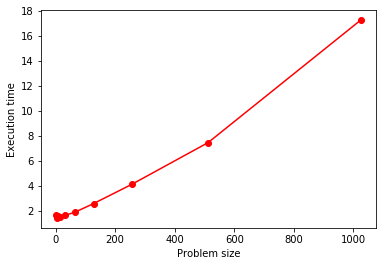

In [55]:
plot_execution_time()

The plot shows that there is almost a linear relation between the problem size and the execution time. So we have achieve som scalability. 

indices :  [[0, 1], [0, 13], [0, 20], [0, 21], [0, 38], [0, 48], [1, 13], [1, 20], [1, 21], [1, 38], [1, 48], [3, 21], [3, 48], [4, 29], [4, 31], [6, 25], [6, 49], [8, 37], [8, 38], [8, 48], [9, 26], [9, 27], [9, 34], [9, 47], [13, 21], [13, 29], [13, 38], [13, 48], [13, 49], [15, 48], [20, 21], [21, 34], [21, 38], [21, 48], [25, 26], [25, 49], [26, 27], [28, 29], [28, 31], [29, 31], [30, 31], [32, 33], [34, 35], [34, 37], [34, 38], [34, 43], [36, 37], [37, 38], [38, 39], [38, 48], [42, 43], [44, 45], [45, 48]]
indices_true :  [[0, 1], [25, 49], [26, 27], [28, 29], [29, 31], [32, 33], [34, 35], [36, 37], [38, 39], [38, 48], [44, 45]]
indices :  [[0, 1], [26, 27], [28, 29], [32, 33], [38, 39]]
indices_true :  [[0, 1], [26, 27], [32, 33], [38, 39]]
indices :  [[0, 1], [26, 27], [28, 29], [32, 33]]
indices_true :  [[0, 1], [26, 27], [32, 33]]
indices :  [[0, 1], [26, 27], [28, 29], [32, 33]]
indices_true :  [[0, 1], [26, 27], [28, 29], [32, 33]]
indices :  [[0, 1], [26, 27], [32, 33]]
ind

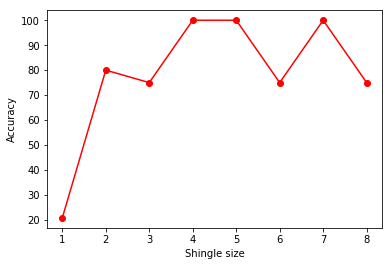

In [56]:
test_shingle_size_accuracy()


Given the data we are using there is no way of calculating the accucary in the proper sense, however we are comparing the true similarity with jaccard (true_sim) and the approximation with minHash (apprx_sim). The similarity or accuracy is defined as follows :

$acc = \frac{ true_{sim} \in approx_sim }{ max(true_{sim}, approx_{sim})}$

The graph shows that single size between 4 and 7 is quite good options. This kind of method can also be used for parameter tuning. 

indices :  [[0, 1], [10, 11], [28, 29], [32, 33], [38, 39]]
indices_true :  [[0, 1], [26, 27], [32, 33]]
indices :  [[0, 1], [26, 27], [32, 33], [38, 39]]
indices_true :  [[0, 1], [26, 27], [32, 33]]
indices :  [[26, 27], [28, 29], [32, 33]]
indices_true :  [[0, 1], [26, 27], [32, 33]]
indices :  [[0, 1], [26, 27], [32, 33]]
indices_true :  [[0, 1], [26, 27], [32, 33]]
indices :  [[0, 1], [26, 27], [32, 33]]
indices_true :  [[0, 1], [26, 27], [32, 33]]
indices :  [[0, 1], [26, 27], [32, 33]]
indices_true :  [[0, 1], [26, 27], [32, 33]]
indices :  [[0, 1], [26, 27], [28, 29], [32, 33]]
indices_true :  [[0, 1], [26, 27], [32, 33]]
indices :  [[0, 1], [26, 27], [32, 33]]
indices_true :  [[0, 1], [26, 27], [32, 33]]
indices :  [[0, 1], [26, 27], [32, 33]]
indices_true :  [[0, 1], [26, 27], [32, 33]]
indices :  [[0, 1], [32, 33]]
indices_true :  [[0, 1], [26, 27], [32, 33]]


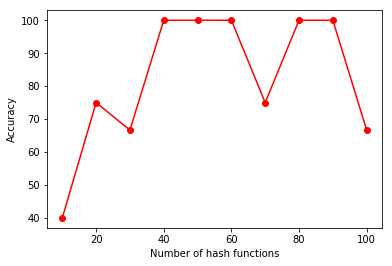

In [58]:
test_NumberOfHashesFunc_accuracy() 

Here we want to test the effect of the number of hash functions to the performance of the minHash similarity approximation. The graph shows that an increasing number of hash functions increase the certainity and the performance of the Minhash. 


## Test with *real* data  

We have used the Quora dataset (https://www.kaggle.com/c/quora-question-pairs/data) for questions duplicates and we will use minHash for finding simalar questions on the character level (nothing about semantic similarity, linguistic  similarity). The data is slightly modified for our purpose, we have filtered out everything in order to quip only text questions.

Read the first 5 questions :


In [59]:
number = 5
data = read_data()
documents = data[0:number]
print(documents)

['What is the step by step guide to invest in share market in india?', 'What is the step by step guide to invest in share market?', 'What is the story of Kohinoor (Koh-i-Noor) Diamond?', 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?', 'How can I increase the speed of my internet connection while using a VPN?']


We will implement a modified version in order to find similar documents and print them out 

In [61]:
def similar_documents(documents, k = 5, s = 0.8) :
    
    signature = MinHashing(documents, k)
    indices = []
    total = len(documents)
    for i in range(total) :
        for j in range(i, total) :
            sim = jaccard_sim_minhashing(signature, i,j)
            if sim > s and (i != j) :
                indices.append([i,j])

    print("similar docs indices : ",indices )
    for i, [x,y] in enumerate(indices) :
        print("Similar docs : ", i)
        print(documents[x])
        print(documents[y])

In [62]:
# Take 20 questions 
number = 20
data = read_data()
documents = data[0:number]
#Parameters 
k = 5
s = 0.8
# Find similar questions :
similar_documents(documents,k,s)

similar docs indices :  [[0, 1]]
Similar docs :  0
What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?


Try with more questions 

In [63]:
# Take 20 questions 
number = 100
data = read_data()
documents = data[0:number]
#Parameters 
k = 5
s = 0.8
# Find similar questions :
similar_documents(documents,k,s)

similar docs indices :  [[0, 1], [26, 27], [32, 33], [50, 51], [82, 83], [84, 85]]
Similar docs :  0
What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?
Similar docs :  1
What was your first sexual experience like?
What was your first sexual experience?
Similar docs :  2
What does manipulation mean?
What does manipulation means?
Similar docs :  3
What are some tips on making it through the job interview process at Medicines?
What are some tips on making it through the job interview process at Foundation Medicine?
Similar docs :  4
When can I expect my Cognizant confirmation mail?
When can I expect Cognizant confirmation mail?
Similar docs :  5
Can I make 50,000 a month by day trading?
Can I make 30,000 a month by day trading?


Try with more questions and lower similarity score :

In [67]:
# Take 20 questions 
number = 100
data = read_data()
documents = data[0:number]
#Parameters 
k = 5
s = 0.5
# Find similar questions :
similar_documents(documents,k,s)

similar docs indices :  [[0, 1], [16, 17], [26, 27], [28, 29], [32, 33], [38, 39], [50, 51], [52, 53], [56, 57], [64, 65], [68, 69], [72, 75], [75, 94], [82, 83], [84, 85], [88, 89]]
Similar docs :  0
What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?
Similar docs :  1
When do you use シ instead of し?
When do you use "&" instead of "and"?
Similar docs :  2
What was your first sexual experience like?
What was your first sexual experience?
Similar docs :  3
What are the laws to change your status from a student visa to a green card in the US, how do they compare to the immigration laws in Canada?
What are the laws to change your status from a student visa to a green card in the US? How do they compare to the immigration laws in Japan?
Similar docs :  4
What does manipulation mean?
What does manipulation means?
Similar docs :  5
Which is the best digital marketing institution in banglore?
Which is the best digital ma

With lower similarity score,we get more data. 

## Locality Sensitive Hashing

We will implement LHS with the help of the signature matrix from minHash. 